# Test of fleGODynamic library

F delta\
-65480.010986328125 N - 180 deg\
-10839.712284503788 N - 30 deg\

exactly as in srticle\
F const:\
15.1875 N - 80.65 deg

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Preparing time: 0.175 s


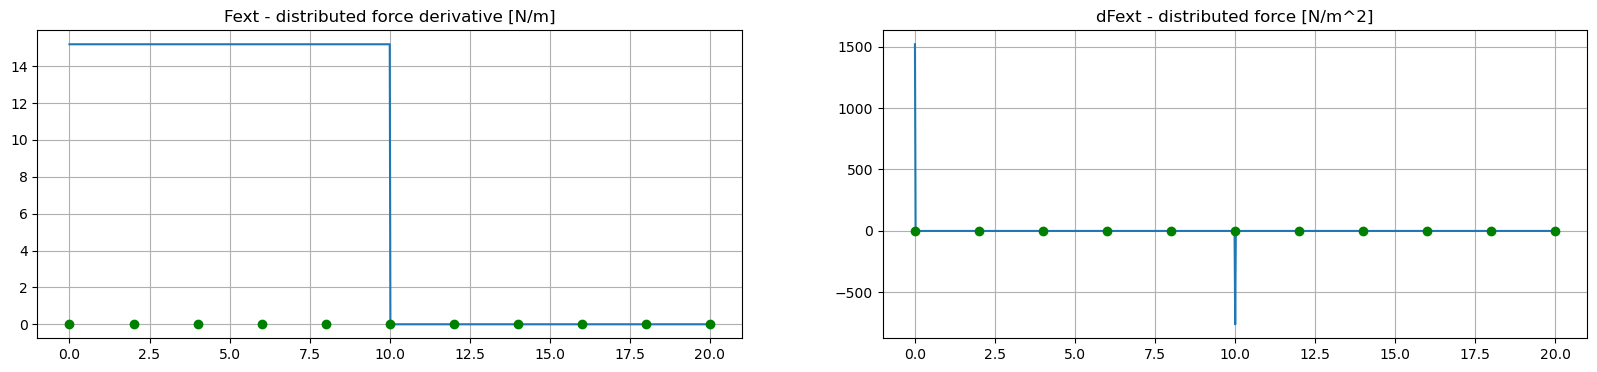

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [108]:
import sys 
import scipy as sp
import sympy as sm
import numpy as np
# del flex_body_instance
del sys.modules["fleGODynamics"]
import fleGODynamics
flex_beam_instance = fleGODynamics.Flex_beam(L=0.02,E=2.95*1e9,h=0.01,w=0.0005,rho=1270)
# flex_beam_instance = fleGODynamics.Flex_beam()
flex_beam_instance.Create_Simulation(disp=False)
flex_beam_instance.FEM(Ne=10,disp=False)
flex_beam_instance.Simulating.Ldivide(steps_per_fe=20,steps_per_fe4optim=100,disp=True)
flex_beam_instance.Simulating.static_preparing(disp=True,Fext=15.1875,l_Fext=0.01,Fext_type='const')

In [109]:
flex_beam_instance.Simulating.static(flag_compute_a_anyway=1,disp=1)

Found numpy zip archive with a approx data. Checking if we can use it!
Checking finished. We cannot use this a approx data as some parameters mismatch. Starting optimization:
iter=1,cost=554131973372.1678
iter=2,cost=554131973372.8892
iter=3,cost=554131973372.5304
iter=4,cost=554131973580.6586
iter=5,cost=554131973476.9308
iter=6,cost=554131973388.4725
iter=7,cost=554131973631.3527
iter=8,cost=554131973710.6006
iter=9,cost=554131973393.5602
iter=10,cost=554131973734.7389
iter=11,cost=554131974021.5067
iter=12,cost=554131973402.8401
iter=13,cost=554131973838.1252
iter=14,cost=554131974435.7991
iter=15,cost=554131973412.5477
iter=16,cost=554131973941.9961
iter=17,cost=554131974950.3923
iter=18,cost=554131973421.1068
iter=19,cost=554131974044.9784
iter=20,cost=554131975574.5125
iter=21,cost=554131973429.7607
iter=22,cost=554131974148.3646
iter=23,cost=554131976299.0442
iter=24,cost=554131973440.2145
iter=25,cost=554131974251.751
iter=26,cost=554131977126.9622
iter=27,cost=554131973451.096

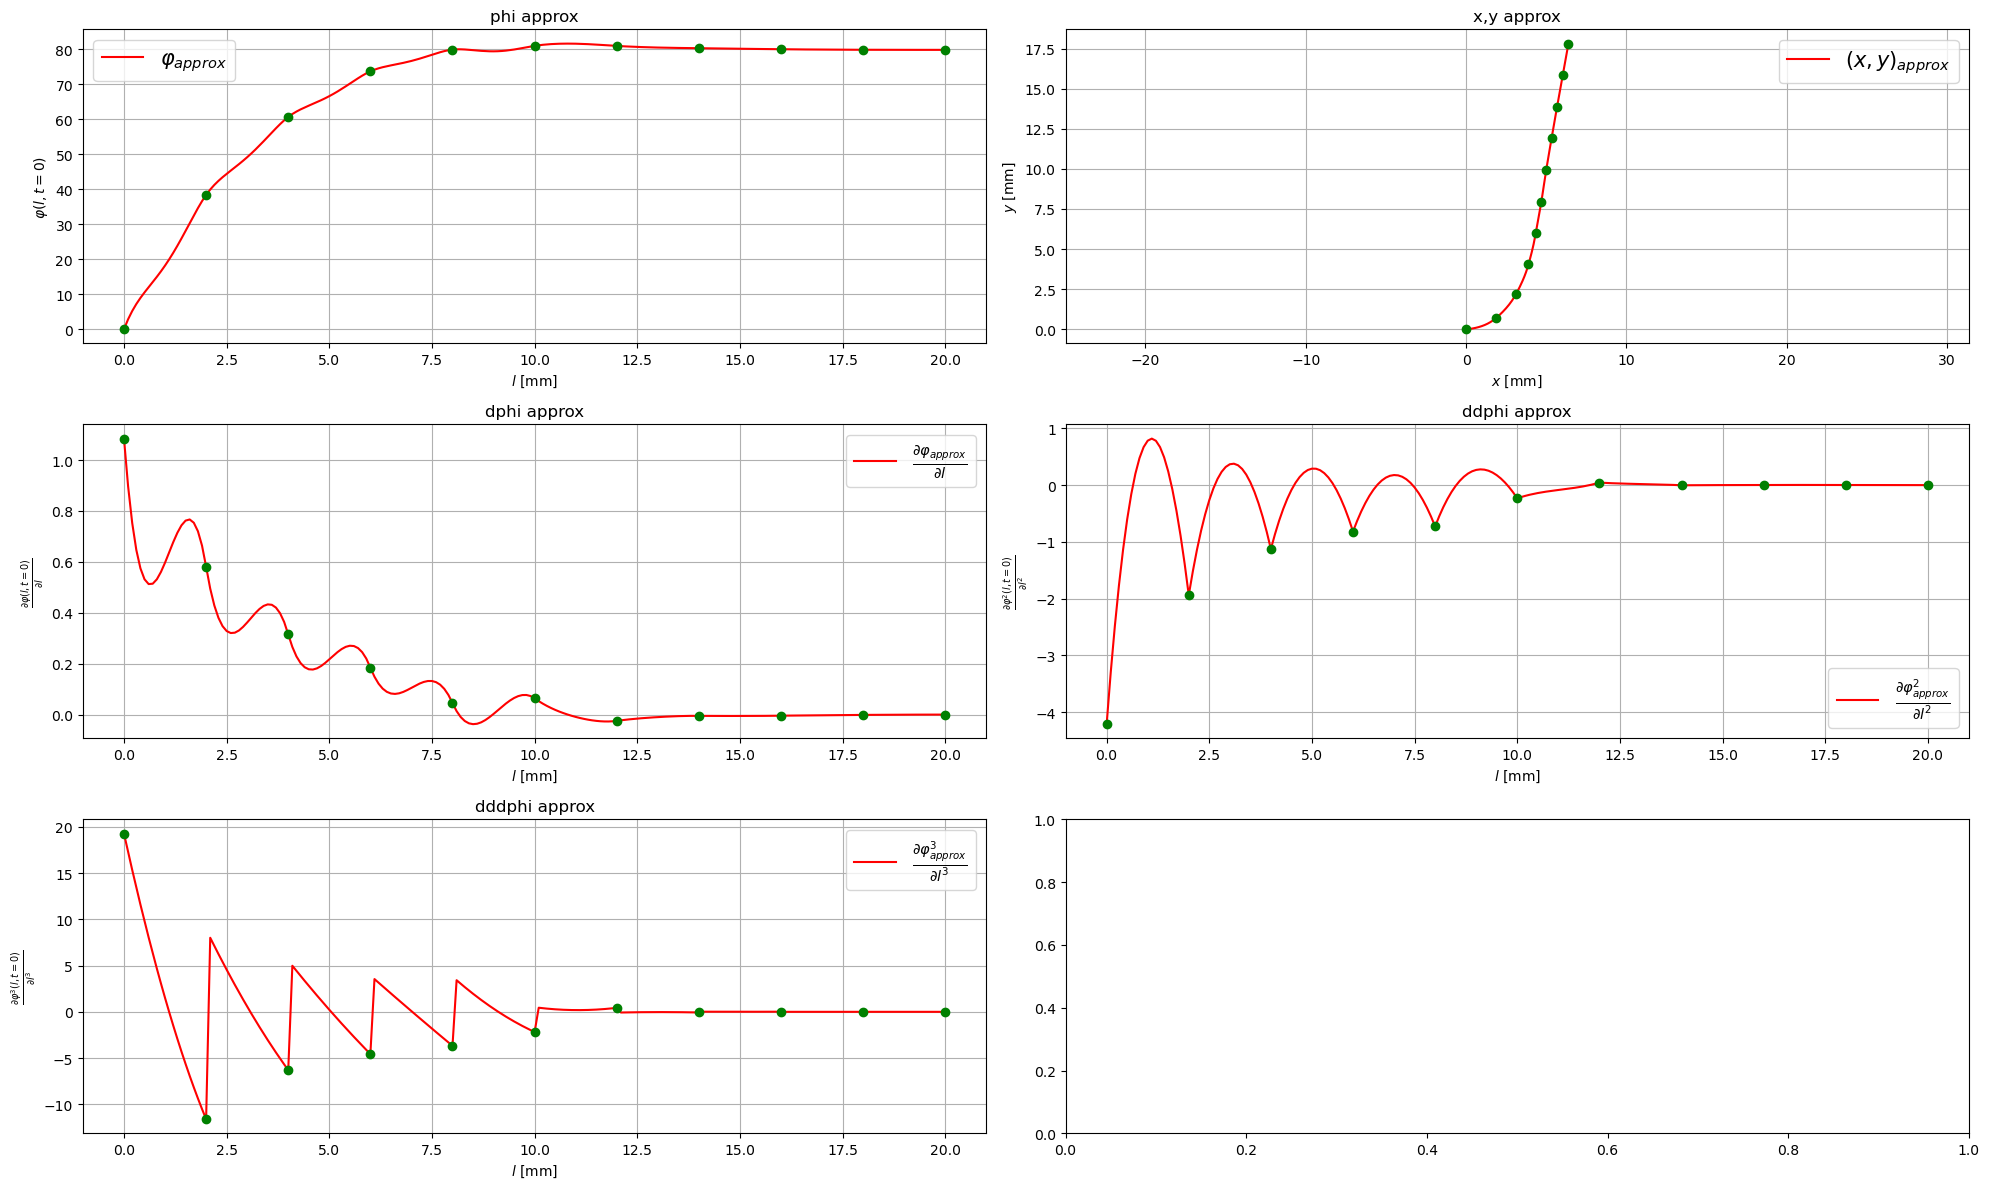

In [110]:
flex_beam_instance.Simulating.phi_approx(disp=False,der_num=2)

iter=1,cost=476.8007849698358,F=10.0
iter=2,cost=382.20970914803206,F=10.5
iter=3,cost=301.53092096252783,F=11.0
iter=4,cost=214.69528272899674,F=11.5
iter=5,cost=106.14510698338744,F=12.5
iter=6,cost=38.80679890646719,F=13.5
iter=7,cost=1.2119935577926195,F=15.5
iter=8,cost=53.44068033176056,F=17.5
iter=9,cost=53.44068033176056,F=17.5
iter=10,cost=5.892606469850657,F=14.5
iter=11,cost=18.93998589851955,F=16.5
iter=12,cost=0.3946955059244344,F=15.0
iter=13,cost=5.892606469850657,F=14.5
iter=14,cost=0.06023551733028287,F=15.25
iter=15,cost=1.2119935577926195,F=15.5
iter=16,cost=0.035901537181018406,F=15.125
iter=17,cost=0.3946955059244344,F=15.0
iter=18,cost=0.0008256505648079061,F=15.1875
15.1875


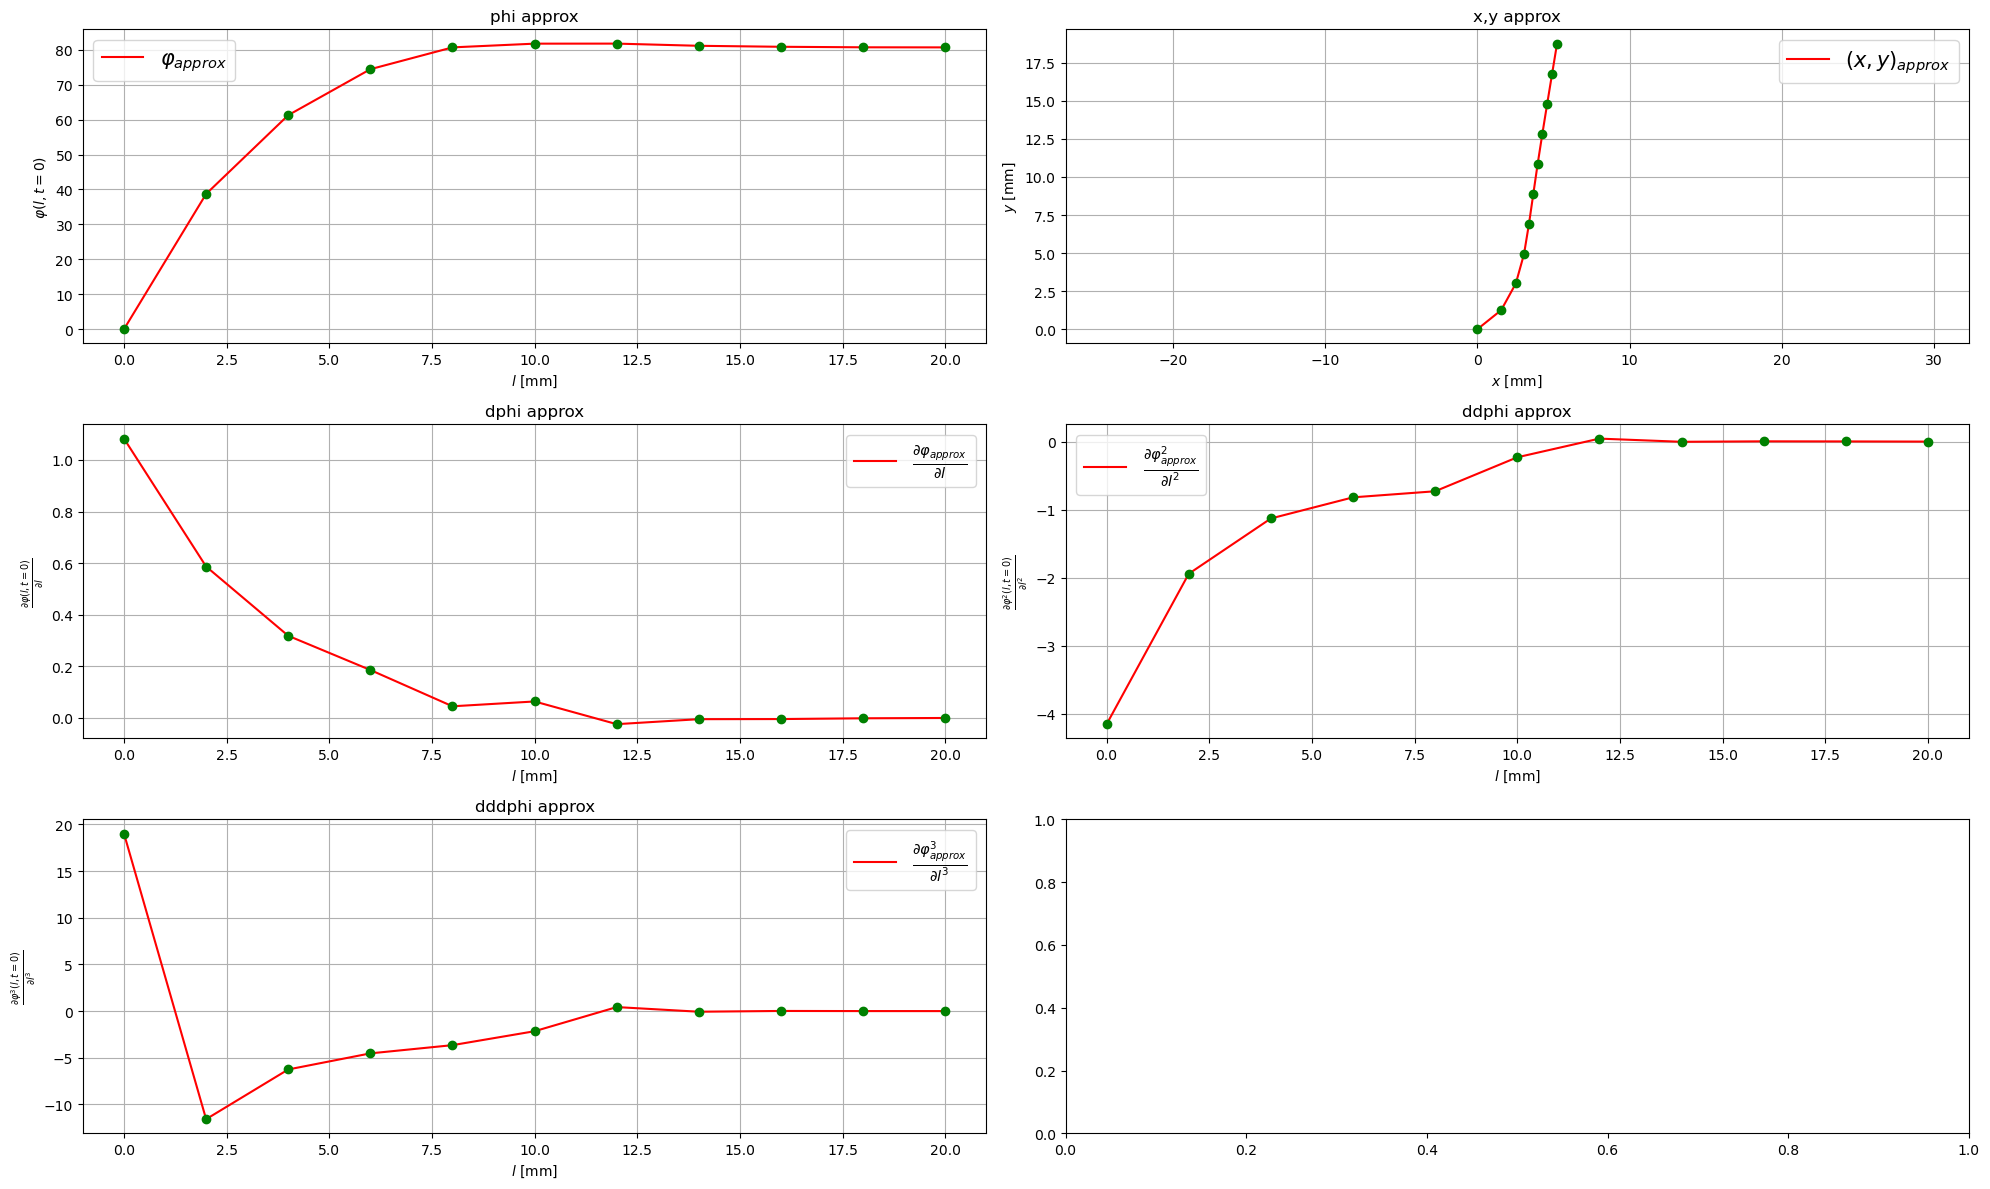

In [71]:
# finding Force for some angle [grad] 
global iter
iter = 0
def fun_optim(F,disp):
    flex_beam_instance.Simulating.static_preparing(disp=False,Fext=F,l_Fext=0.01,Fext_type='const')
    flex_beam_instance.Simulating.static(disp=False,flag_compute_a_anyway=1)
    cost = (np.rad2deg(flex_beam_instance.Simulating.phi_end)-80.65)**2
    if disp:
        global iter
        iter += 1
        print("iter={},cost={},F={}".format(iter,cost,F[0]))
    return cost

F0 = 10
F = sp.optimize.minimize(fun_optim,F0,args=(1),method='Nelder-Mead',tol=1e-1).x[0]
print(F)

flex_beam_instance.Simulating.static_preparing(disp=False,Fext=F,l_Fext=0.01,Fext_type='const')
flex_beam_instance.Simulating.static(disp=False,flag_compute_a_anyway=1)
flex_beam_instance.Simulating.phi_approx(disp=False,der_num=2)

Found numpy zip archive with preparing data: psi vectors. Checking if we can use it!
Checking finished. Using loaded data
Found an approximation. Will use it!
evaluation time: 2.005 ms
time for 1 step: 0.2 us


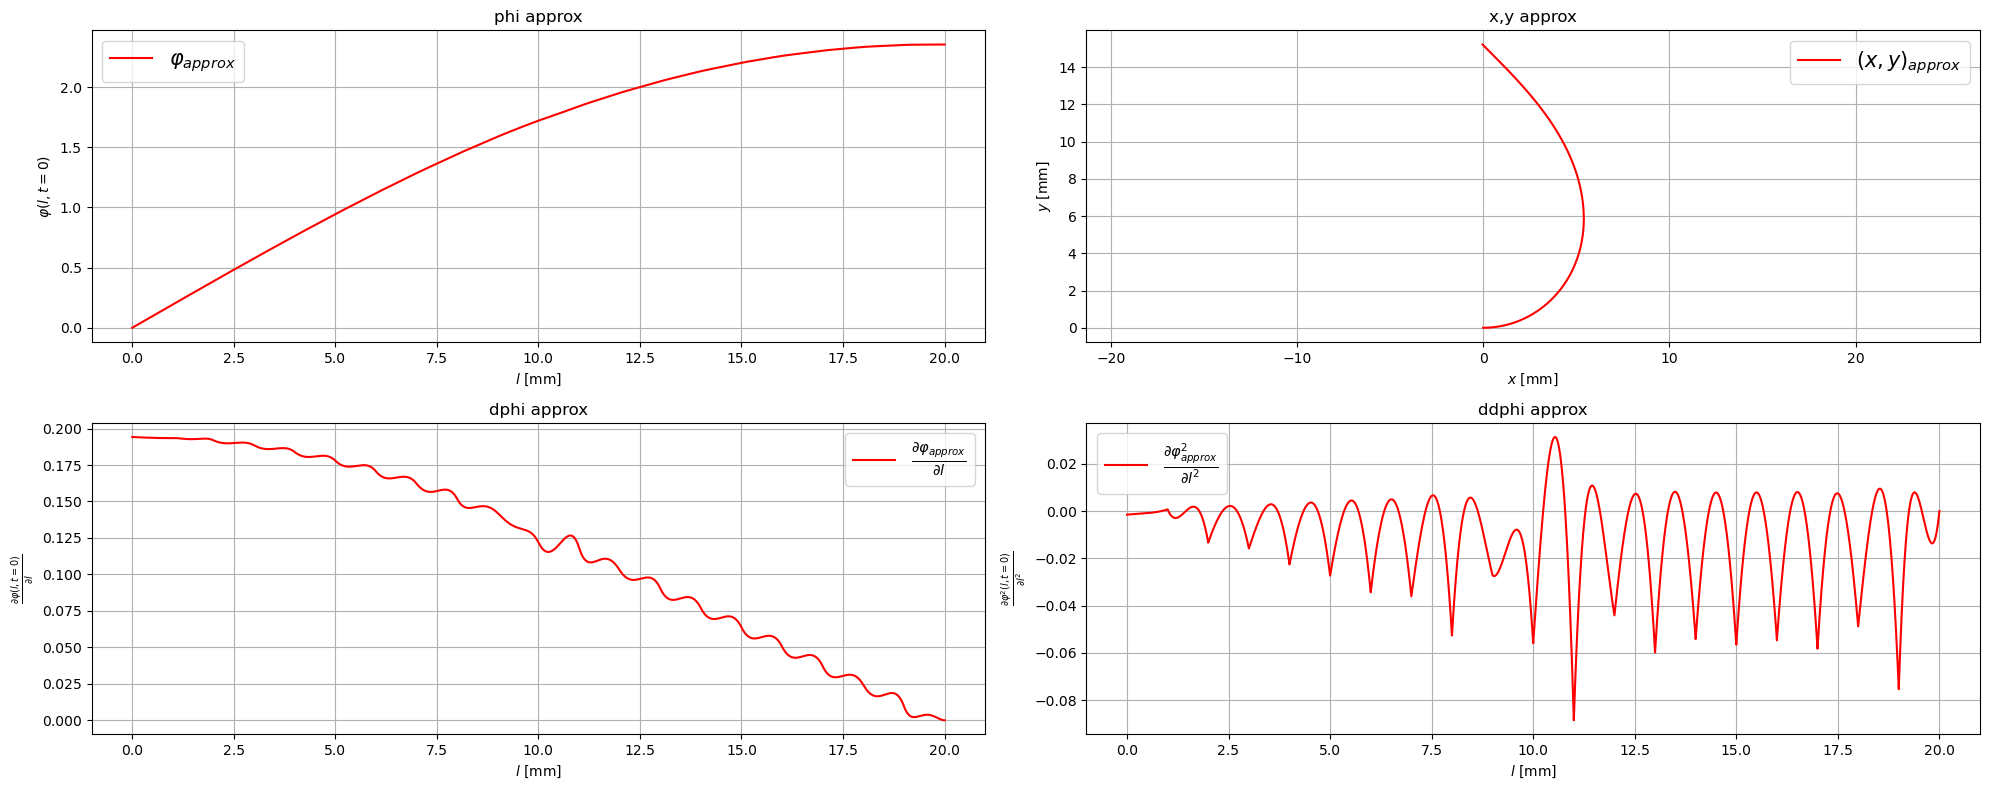

In [37]:
l = sm.symbols("l")
phi = 0.6*(1.7*sm.sin(1.7e-1*l)+0.3*(sm.exp(l/10))-0.3)
flex_beam_instance.Simulating.set_phi(phi,disp=False)
flex_beam_instance.Simulating.create_a(disp=False)
# flex_beam_instance.Simulating.show_one_element_approx(e=5)
flex_beam_instance.Simulating.phi_approx_preparing()

flex_beam_instance.Simulating.phi_approx(disp_time=True,der_num=2)

In [347]:
str_a = np.str_( np.round(flex_beam_instance.Simulating.get_a_diff(),8)).replace('\n', ' ').replace(' ',',').replace(',,,,',',').replace(',,,',',').replace(',,',',') 
print( str_a[0] + str_a[2:])# + str_a[-1] )
# print(len(np.round(flex_beam_instance.Simulating.get_a_diff(),3)))

[1.41578856e+00,-6.10008740e-01,1.22924835e+00,1.13566447e+00,-3.22195000e-02,2.32580266e+00,1.02980363e+00,-1.09878364e+00,3.25681225e+00,8.40359340e-01,-1.19184744e+00,4.03437107e+00,8.41138370e-01,1.22068872e+00,4.95056893e+00,9.38759460e-01,2.95114000e-02,5.88225753e+00,9.25089010e-01,-7.16830000e-02,6.83439881e+00,1.08487547e+00,1.93707569e+00,8.14823756e+00,1.71180847e+00,4.39714748e+00,1.07043006e+01,4.88061475e+00,2.44850784e+01,1.07764898e+01,-2.31618232e+01,-3.74638706e+02,-3.39549043e+01,-2.19141041e+01,3.87916850e+02,-3.33712377e+01,5.21216964e+00,-3.34011555e+01,-3.09494616e+01,1.59495789e+00,-2.87172440e+00,-2.96114429e+01,1.23698454e+00,-1.08477492e+00,-2.84629532e+01,1.16297883e+00,9.77746300e-02,-2.73188798e+01,1.14560533e+00,-3.72989860e-01,-2.62412418e+01,9.96251130e-01,-1.38678172e+00,-2.53817474e+01,7.47327850e-01,-1.27500669e+00,-2.48040844e+01,3.34886930e-01,-2.84356653e+00,-2.47078389e+01]


In [356]:
a_approx = flex_beam_instance.Simulating.get_a_approx()
# a_approx = np.array([0.,1.398054,0.522382,0.984477,-0.24426,0.254438,0.984477,-0.24426,0.254438,1.000862,-0.248743,0.255066,1.000862,-0.248743,0.255066,0.999999,-0.248574,0.255055,0.999999,-0.248574,0.255055,1.,-0.248575,0.255055,1.,-0.248575,0.255055,1.,-0.248575,0.255055,1.,-0.248575,0.255055,1.,-0.248574,0.255055,1.,-0.248574,0.255055,0.999948,-0.248585,0.255054,0.999948,-0.248585,0.255054,0.993998,-0.249492,0.254917,0.993998,-0.249492,0.254917,1.206959,-0.150128,0.269416,1.206959,-0.150128,0.269416,2.049172,1.177882,0.710173])
str_a = np.str_( np.round(a_approx,6)).replace('\n', ' ').replace(' ',',').replace(',,,,',',').replace(',,,',',').replace(',,',',') 
print( str_a[0] + str_a[2:] )
# print(len(a_approx))

[0.00000000e+00,1.67212410e+01,1.68504858e+02,1.93746360e+01,2.67233400e+01,-3.51476300e+01,1.93746360e+01,2.67233400e+01,-3.51476300e+01,3.55308900e+01,2.41189850e+01,3.45420600e+00,3.55308900e+01,2.41189850e+01,3.45420600e+00,5.17201620e+01,2.36989970e+01,-1.81464200e+00,5.17201620e+01,2.36989970e+01,-1.81464200e+00,6.73297000e+01,2.25296180e+01,-1.57119600e+00,6.73297000e+01,2.25296180e+01,-1.57119600e+00,8.20123680e+01,2.17527450e+01,1.03728250e+01,8.20123680e+01,2.17527450e+01,1.03728250e+01,9.26998790e+01,2.85221500e+00,-1.56044599e+02,9.26998790e+01,2.85221500e+00,-1.56044599e+02,8.96730970e+01,4.56048840e+01,1.80411514e+03,8.96730970e+01,4.56048840e+01,1.80411514e+03,1.25568848e+02,3.95645510e+01,-2.43380092e+03,1.25568848e+02,3.95645510e+01,-2.43380092e+03,7.37349340e+01,-6.80470100e+02,-8.04712493e+03,7.37349340e+01,-6.80470100e+02,-8.04712493e+03,-1.23566600e+03,-1.45677371e+03,-5.51061682e+02,-1.23566600e+03,-1.45677371e+03,-5.51061682e+02,-2.55594933e+03,-6.29898235e+02,9.

In [359]:
flex_beam_instance.Simulating.set_a_approx(a_approx*1e-4)

Found an approximation. Will use it!
evaluation time: 6.041 ms
time for 1 step: 0.604 us


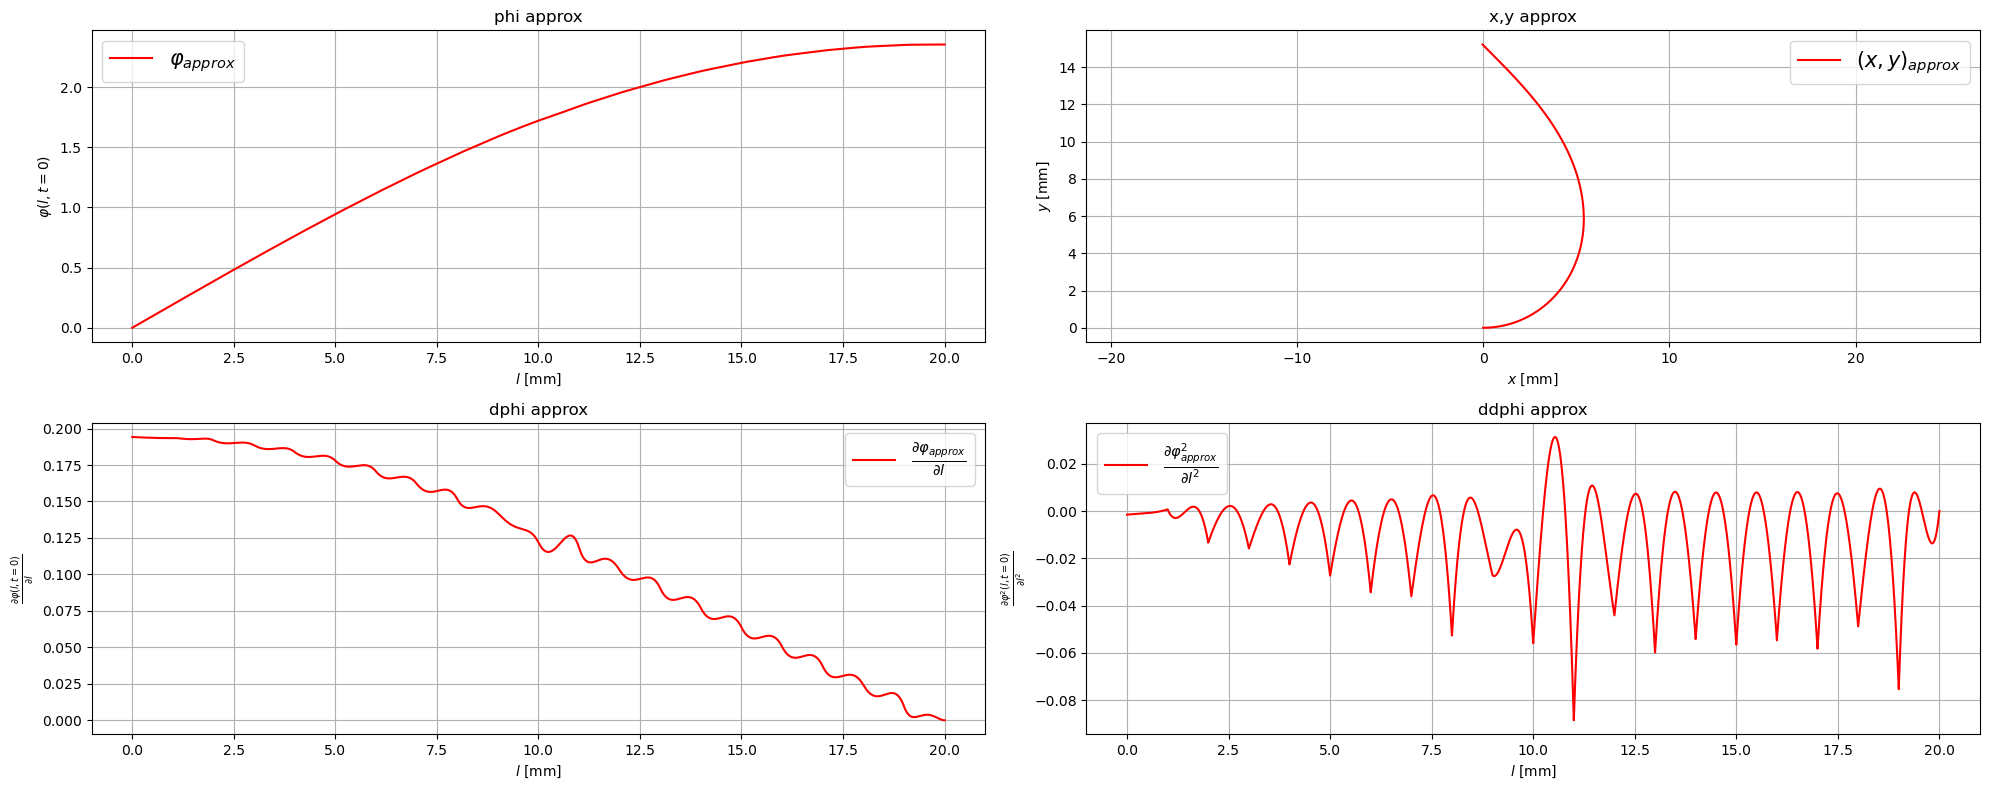

In [38]:
flex_beam_instance.Simulating.phi_approx(disp_time=True,der_num=2)